# RIMORPHIS Workflow

To run this workflow, you must sign up for [Google Earth Engine](https://signup.earthengine.google.com/#!/), and enter an authentication code to initialize it. 

In [1]:
!pip install geemap

### Import Libraries


In [2]:
from glob import glob
import os

import hydrofunctions as hf
import earthpy as et
import seaborn as sns
import pandas as pd
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import folium
import matplotcheck.notebook as nb
from matplotcheck.base import PlotTester
import matplotcheck.autograde as ag
import numpy as np


# Installs geemap package
import geemap.eefolium as geemap

# We are adding this for you as there is a bug in hydrofunctions that
# Turns off plotting
%matplotlib inline

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

# Authenticates and initializes Earth Engine
import ee

### Authenticate Google Earth Engine

In [3]:
ee.Authenticate()
ee.Initialize()  

Enter verification code: 4/1AX4XfWhLW7ZdsukPxbz0Dl6HQ7_LveVTaFijHrW0JY-B2dgASNDpw68BENw

Successfully saved authorization token.


# Overarching functions:
- input river
- input time series
- feed both into GEE and NWIS

# Site info for Vicksburg MS

Specify the start and end time for time series as well as geographic region to process. This can be changed to river gages and time periods.

In [4]:
#site number for NWIS gage
site_no = ['07289000']

#Coordinates for the bounds of a rectangle at Vicksburg
xMin = -91.2
yMin = 32
xMax = -90.8
yMax = 32.7

wet_season_start = '2019-03-15'
wet_season_end = '2019-05-01'

dry_season_start = '2019-9-01'
dry_season_end = '2019-10-01'

# Google Earth Engine

In [5]:
Map = geemap.Map(center=[32.3,-90.9], zoom= 11)
Map

### GEE Script

In [6]:
# Import the Sentinel 2 collection as sentinel 2
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR').filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))

rectangleGeoJSON = ee.Geometry.Rectangle(
  [
    [xMin, yMin],
    [xMax, yMax]   # max x and y
  ]
)

miss_bnds = ee.FeatureCollection([
    ee.Feature(
        rectangleGeoJSON,
        {'name': 'Mississippi Vicksburg', 'fill': 1}),
    ])

dry_season = sentinel2.filterBounds(miss_bnds).filterDate(dry_season_start, dry_season_end).mosaic().clip(miss_bnds)

wet_season = sentinel2.filterBounds(miss_bnds).filterDate(wet_season_start, wet_season_end).mosaic().clip(miss_bnds)


# Palettes for Visualization
trueColor_palette = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000};
waterPalette = ['red', 'yellow', 'green', 'blue'];
#print(miss_bnds)


### Display Earth Engine True Color Images layers in Dry Season

In [7]:
Map = geemap.Map(center=[32.3,-90.9], zoom= 12)
Map.addLayer(dry_season, trueColor_palette, '2019 Dry season true color');
Map.addLayerControl()
Map

### Display Earth Engine True Color Images layers in Wet Season

In [8]:
Map = geemap.Map(center=[32.3,-90.9], zoom= 12)
Map.addLayer(wet_season, trueColor_palette, '2019 Wet season true color');
Map.addLayerControl()
Map

# Hydrofunctions

In [9]:
# In this cell create a function to support figure one that opens
# data using hydrofunctions and returns a dataframe  with
# x,y location, site name and discharge data

def create_df(site, start, end):
    """Imports data to dataframe, adds geolocation and stream gage site name

    Parameters
    ----------
    site : string
        Site number as specified by USGS
        
    start : string
        Desired start date for data
        
    end : string
        Desired end date for data 

    Returns
    -------
    response_df : dataframe
        Dataframe created from downloaded csv    """
    
    # YOUR CODE HERE
    
    # Generate dataframe from NWIS for gage discharge data at specified sites
    response = hf.NWIS(site, 'dv', start, end, parameterCd='00060')
    response_df = response.df()

    # Rename columns for discharge and flags
    response_df.columns = ('discharge', 'qualifiers')
    
    # Add column for site name
    response_df["sitename"] = hf.get_nwis_property(response.json, key='siteName')[0]
   
    # Add columns for gage location latitude and longitude
    geolocation =   hf.get_nwis_property(response.json, key='geoLocation')[0]
    response_df["latitude"] = geolocation["geogLocation"]["latitude"]
    response_df["longitude"] = geolocation["geogLocation"]["longitude"]

    
    return response_df


# Create dataframe from NWIS site

In [10]:
site_df = create_df(site_no, wet_season_start, wet_season_end)

site_df 

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07289000&parameterCd=00060&startDT=2019-03-15&endDT=2019-05-01


,discharge,qualifiers,sitename,latitude,longitude
datetimeUTC,,,,,
2019-03-15 00:00:00+00:00,1870000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
2019-03-16 00:00:00+00:00,1870000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
2019-03-17 00:00:00+00:00,1870000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
2019-03-18 00:00:00+00:00,1860000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
2019-03-19 00:00:00+00:00,1860000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
2019-03-20 00:00:00+00:00,1860000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
2019-03-21 00:00:00+00:00,1850000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
2019-03-22 00:00:00+00:00,1850000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
2019-03-23 00:00:00+00:00,1840000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833


[Text(0.5, 0, 'Date (Month-Day)'),
 Text(0, 0.5, 'Daily Mean Stream Discharge \n (cu. ft. / second)')]

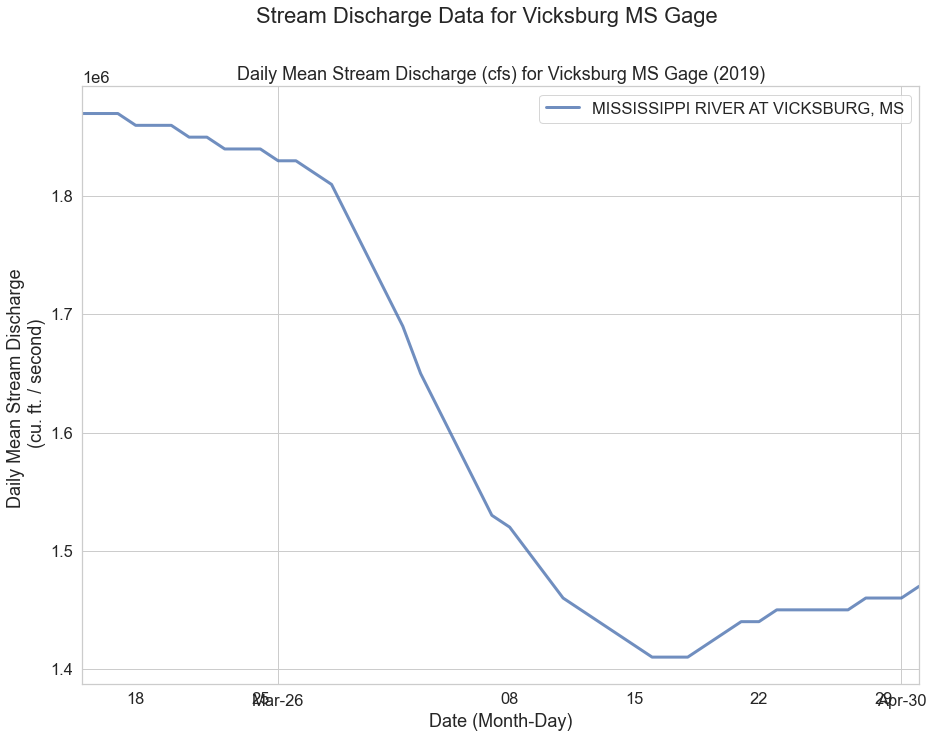

In [11]:
# Define plot space, overall size and title
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 11))

fig.suptitle(
    "Stream Discharge Data for Vicksburg MS Gage", fontsize=22)

# Loop for plotting Subplot 1
for site_name, group in site_df.groupby('sitename'):
    group.groupby('sitename').plot(y='discharge',
                                   title="Daily Mean Stream Discharge (cfs) for Vicksburg MS Gage (2019)",
                                   label=site_name,
                                   linewidth=3.0,
                                   ax=ax1,
                                   alpha=.8)

# Define the date format for Subplot 1, set axis labels
date_form = DateFormatter("%b-%d")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=5))
ax1.set(xlabel="Date (Month-Day)",
        ylabel="Daily Mean Stream Discharge \n (cu. ft. / second)")

#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 11})

# NWDI Analysis

### Display Earth Engine the NDWI images with a color palette in Dry Season

In [12]:
dry_season_Map = geemap.Map(center=[32.3,-90.9], zoom= 11)
ndwi_dry = dry_season.normalizedDifference(['B3', 'B8']);
dry_season_Map.addLayer(ndwi_dry, {'min': -1, 'max': 0.5, 'palette': waterPalette}, '2019 Wet season NDWI');
dry_season_Map

### Display Earth Engine the NDWI images with a color palette in Wet Season

In [13]:
wet_season_Map = geemap.Map(center=[32.3,-90.9], zoom= 11)
ndwi_wet = wet_season.normalizedDifference(['B3', 'B8']);
wet_season_Map.addLayer(ndwi_wet, {'min': -1, 'max': 0.5, 'palette': waterPalette}, '2019 Wet season NDWI');
wet_season_Map

# Extract Water Pixels

In [14]:
water_Map = geemap.Map(center=[32.3,-90.9], zoom= 11)

In [15]:
ndwi_threshold = 0
water_image = ndwi_wet.gt(ndwi_threshold).selfMask()

In [16]:
water_Map.addLayer(water_image, {'palette': 'blue'}, 'Water image')

In [17]:
water_Map

# Transfer from Raster to Vector

In [18]:
vector_Map = geemap.Map(center=[32.3,-90.9], zoom= 11)

In [19]:
water_vector = water_image.reduceToVectors(scale=30, maxPixels=60000000, geometry = rectangleGeoJSON)
vector_Map.addLayer(water_vector, {}, 'Water vector')
vector_Map